In [1]:
pip install numpy matplotlib scikit-learn gudhi pot transformers -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
!conda install -c alubbock pygraphviz -y

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.



In [3]:
text_1 = ["Learn deep learning",

          "deep learning is fun", 
          
          "Deep learning extracts features from data"]

In [6]:

import numpy as np
import gudhi as gd
import torch
from gudhi.wasserstein.barycenter import lagrangian_barycenter as bary
from gudhi.persistence_graphical_tools import plot_persistence_diagram
import matplotlib.pyplot as plt
import transformers
from transformers import BertTokenizer, BertModel
from transformers import BertModel, BertTokenizerFast
from transformers import AutoTokenizer, AutoModel
from scipy.spatial import distance_matrix
import itertools
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations
from networkx.drawing.nx_pydot import graphviz_layout


def compute_output_model(tokenizer, model, sentence, layer, head):

    # Tokenize input and convert to tensor
    inputs = tokenizer(sentence, return_tensors="pt")

    # Forward pass
    # Specify `output_hidden_states=True` when calling the model
    outputs = model(**inputs, output_attentions=True, output_hidden_states=True)

    # Obtain the attention weights
    attentions = outputs.attentions

    # Obtain the attention weights for the specific layer and head
    S = attentions[layer][0, head]

    # Obtain the value vectors
    model.eval()
    with torch.no_grad():
        hidden_states = outputs.hidden_states[layer]
        all_W_v = model.encoder.layer[layer].attention.self.value.weight
        num_heads = model.config.num_attention_heads
        head_dim = model.config.hidden_size // num_heads
        W_v_heads = all_W_v.view(num_heads, head_dim, model.config.hidden_size)
        W_v = W_v_heads[head]
        V = torch.matmul(hidden_states, W_v.t())

    # Compute the output O
    O = torch.matmul(S, V)

    return O



def compute_phrase_distances_and_homology(tokenizer, context_vectors, sentence, phrase):

    # Tokenize the sentence and the phrase
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
    phrase_tokens = tokenizer.encode(phrase, add_special_tokens=False)

    # Find the indices of the phrase tokens in the sentence
    phrase_indices = []
    phrase_length = len(phrase_tokens)
    for i in range(len(sentence_tokens) - phrase_length + 1):
        if sentence_tokens[i:i+phrase_length] == phrase_tokens:
            phrase_indices.extend(range(i, i+phrase_length))
            break

    # Extract the context vectors for the phrase
    phrase_context_vectors = context_vectors[0, phrase_indices]

    # Detach the tensor and convert to numpy array
    phrase_context_vectors_np = phrase_context_vectors.detach().numpy()

    # Compute the pairwise Euclidean distances among the phrase context vectors
    distances = distance_matrix(phrase_context_vectors_np, phrase_context_vectors_np)

    # Compute the persistent homology of the distance matrix
    rips_complex = gd.RipsComplex(distance_matrix=distances, max_edge_length=np.max(distances))
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=5)
    persistent_homology = simplex_tree.persistence(min_persistence=0.001)

    return persistent_homology, simplex_tree



def print_simplex_tree(persistent_homology, sentence_index, layer_index, head_index):
    # Get the homology and simplex tree for the specified sentence, layer, and head
    homology, simplex_tree = persistent_homology[sentence_index][layer_index][head_index]

    print(f"Simplex tree for sentence {sentence_index+1}, layer {layer_index+1}, head {head_index+1}:")

    for simplex, filtration_value in simplex_tree.get_filtration():
        print(f"Simplex: {simplex}, Filtration value: {filtration_value}")

    print("\n")



def print_simplex_tree_with_tokens(persistent_homology, tokenizer, sentence, sentence_index, layer_index, head_index):
    # Get the homology and simplex tree for the specified sentence, layer, and head
    homology, simplex_tree = persistent_homology[sentence_index][layer_index][head_index]

    # Tokenize the sentence
    sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)

    print(f"Simplex tree for sentence {sentence_index+1}, layer {layer_index+1}, head {head_index+1}:")

    for simplex, filtration_value in simplex_tree.get_filtration():
        # Convert the indices of the simplex into tokens
        simplex_tokens = [sentence_tokens[i] for i in simplex]

        # Convert the tokens back into words
        words = tokenizer.decode(simplex_tokens)

        print(f"Simplex: {simplex}, Words: {words}, Filtration value: {filtration_value}")

    print("\n")



def plot_simplex_tree(simplex_tree):
    '''Plots the Hasse diagram of the simplex tree'''

    # Create a directed graph
    graph = nx.DiGraph()

    # Create a node for each simplex in the simplex tree
    for simplex_tuple in simplex_tree.get_skeleton(1):
        simplex, filtration_value = simplex_tuple
        # Convert the simplex (which is a list of vertices) into a string so that it can be used as a node label
        simplex_str = ', '.join(str(vertex) for vertex in simplex)
        graph.add_node(simplex_str)

    # Add an edge for each pair of simplices where one is a face of the other
    for simplex_tuple in simplex_tree.get_skeleton(2):
        simplex, filtration_value = simplex_tuple
        simplex_str = ', '.join(str(vertex) for vertex in simplex)
        for sub_simplex in itertools.combinations(simplex, len(simplex)-1):
            sub_simplex_str = ', '.join(str(vertex) for vertex in sub_simplex)
            graph.add_edge(sub_simplex_str, simplex_str)

    # Draw the graph
    nx.draw(graph, with_labels=True)
    plt.show()



def plot_simplex_tree_with_tokens(simplex_tree, tokens):
    '''Plots the Hasse diagram of the simplex tree with tokens as node labels'''

    # Create a directed graph
    graph = nx.DiGraph()

    # Create a node for each simplex in the simplex tree
    for simplex_tuple in simplex_tree.get_skeleton(1):
        simplex, filtration_value = simplex_tuple
        # Convert the simplex (which is a list of vertices) into a string of tokens so that it can be used as a node label
        simplex_str = ', '.join(tokens[vertex] for vertex in simplex)
        graph.add_node(simplex_str)

    # Add an edge for each pair of simplices where one is a face of the other
    for simplex_tuple in simplex_tree.get_skeleton(2):
        simplex, filtration_value = simplex_tuple
        simplex_str = ', '.join(tokens[vertex] for vertex in simplex)
        for sub_simplex in itertools.combinations(simplex, len(simplex)-1):
            sub_simplex_str = ', '.join(tokens[vertex] for vertex in sub_simplex)
            graph.add_edge(sub_simplex_str, simplex_str)

    # Draw the graph
    nx.draw(graph, node_color='skyblue', with_labels=True)
    plt.show()



def plot_simplex_tree_as_tree(simplex_tree):
    '''Plots the tree diagram of the simplex tree using the filtration order and only including edges 
    between cimplices of consecutive dimension'''    

    G = nx.DiGraph()
    already_included = set()

    for simplex, filtration in simplex_tree.get_filtration():
        simplex = tuple(sorted(simplex))
        G.add_node(simplex)
        if len(simplex) > 1:
            # Only add edges for immediate sub-simplices
            for sub_simplex in combinations(simplex, len(simplex)-1):
                sub_simplex = tuple(sorted(sub_simplex))
                if sub_simplex in G.nodes() and sub_simplex not in already_included:
                    G.add_edge(sub_simplex, simplex)
                    already_included.add(sub_simplex)

    # Create a new figure with desired size
    plt.figure(figsize=(15, 5))  # adjust as needed

    # Use Graphviz for layout
    pos = graphviz_layout(G, prog='dot')

    # nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue')

    # edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)

    # labels
    nx.draw_networkx_labels(G, pos, font_size=8)

    plt.show()



def plot_simplex_tree_as_tree_with_tokens(simplex_tree, tokens):
    '''Plots the tree diagram of the simplex tree using the filtration order and only including edges 
    between simplices of consecutive dimension. The nodes are labeled with tokens instead of simplices'''    

    G = nx.DiGraph()
    already_included = set()

    for simplex, filtration in simplex_tree.get_filtration():
        simplex = tuple(sorted(simplex))
        G.add_node(simplex)
        if len(simplex) > 1:
            # Only add edges for immediate sub-simplices
            for sub_simplex in combinations(simplex, len(simplex)-1):
                sub_simplex = tuple(sorted(sub_simplex))
                if sub_simplex in G.nodes() and sub_simplex not in already_included:
                    G.add_edge(sub_simplex, simplex)
                    already_included.add(sub_simplex)

    # Create a new figure with desired size
    plt.figure(figsize=(12, 3))  # adjust as needed

    # Use Graphviz for layout
    pos = graphviz_layout(G, prog='dot')

    # nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue')

    # edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=10)

    # labels
    labels = {simplex: ' '.join(tokens[i] for i in simplex) for simplex in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8)

    plt.show()



### Compute Context Vectors for Every Head in Every Layer

In [7]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = AutoModel.from_pretrained("xlm-roberta-base", output_attentions=True) 

# Get the number of layers and heads in the model
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

context = []
for i in range(len(text_1)):
    sentence_context = []
    for layer in range(num_layers):
        layer_context = []
        for head in range(num_heads):
            layer_context.append(compute_output_model(tokenizer, model, text_1[i], layer, head))
        sentence_context.append(layer_context)
    context.append(sentence_context)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now, we can print the context vectors for a specific `head` and `layer` of the model for one `paragraph` of `text_1` as follows (note there are `5` tokens, and this `5` context vectors, each of dimension `64`):

In [8]:
paragraph = 0
layer = 11
head = 11

print(context[paragraph][layer][head].shape)
print(context[paragraph][layer][head])

torch.Size([1, 5, 64])
tensor([[[-1.5110e-01, -1.7930e-01,  5.2505e-02,  1.8515e-02,  1.9811e-01,
          -2.5777e-01,  6.1795e-02,  2.1820e-01,  2.9432e-02, -7.3397e-02,
          -2.6711e-02, -7.6877e-02, -1.2014e-01, -1.2921e-01, -1.5615e-01,
          -1.1451e-01,  1.8081e-01,  1.4468e-01, -1.6595e-02,  1.8458e-01,
           1.5527e-01,  8.9335e-02, -3.2818e-01, -3.4098e-02,  2.3501e-02,
          -2.3665e-02, -2.3332e-02, -1.7782e-01, -1.7357e-02, -2.2077e-01,
           2.1933e-01, -2.2668e-01, -6.6278e-02, -8.3397e-02, -1.6453e-01,
          -7.0863e-02, -2.7706e-01,  1.6716e-02,  4.3258e-02, -2.3294e-01,
          -3.4047e-02,  1.0261e-02, -9.4472e-02,  3.6195e-02,  2.4391e-02,
          -4.4365e-01, -1.8049e-01,  4.3648e-02, -9.7338e-02, -1.5771e-01,
           2.5957e-01,  6.0379e-02, -1.5402e-01, -7.5841e-02, -1.0873e-01,
          -4.9085e-03, -4.6296e-02,  4.1283e-02, -1.1106e-01, -1.4454e-01,
           9.9876e-02, -1.0082e-01, -2.1242e-02, -1.6899e-01],
         [-2.4

### Compute the peristent homology

Now, we compute the persisten homology of a subset of the tokens in each text (here we just use the entire sentence), for each `head` in each `layer` as follows:

In [9]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# Get the number of layers and heads in the model
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

persistent_homology = []

for i in range(len(text_1)):
    sentence_persistent_homology = []
    for layer in range(num_layers):
        layer_persistent_homology = []
        for head in range(num_heads):
            layer_persistent_homology.append(compute_phrase_distances_and_homology(tokenizer, context[i][layer][head], text_1[i], text_1[i]))
        sentence_persistent_homology.append(layer_persistent_homology)
    persistent_homology.append(sentence_persistent_homology)


### Print a Simplex Tree

In [10]:
print_simplex_tree_with_tokens(persistent_homology, tokenizer, text_1[0], sentence_index=0, layer_index=0, head_index=0)


Simplex tree for sentence 1, layer 1, head 1:
Simplex: [0], Words: Learn, Filtration value: 0.0
Simplex: [1], Words: deep, Filtration value: 0.0
Simplex: [2], Words: learning, Filtration value: 0.0
Simplex: [1, 2], Words: deep learning, Filtration value: 0.3211813720369765
Simplex: [0, 2], Words: Learn learning, Filtration value: 0.8442628927861293
Simplex: [0, 1], Words: Learn deep, Filtration value: 0.9469744286580515
Simplex: [0, 1, 2], Words: Learn deep learning, Filtration value: 0.9469744286580515




In [11]:
# Tokenize the sentence
sentence_index = 0
sentence_tokens = tokenizer.encode(text_1[sentence_index], add_special_tokens=False)

print(f"Sentence {sentence_index+1} tokens:")
for token in sentence_tokens:
    # Convert the token back into a word
    word = tokenizer.decode([token])
    print(f"Token: {token}, Word: {word}")


Sentence 1 tokens:
Token: 134031, Word: Learn
Token: 53894, Word: deep
Token: 52080, Word: learning


### Plotting Simplex Tree Based on Inclusion

Plotting the simplex tree based solely on inclusion does not give a tree, it only gives a directed acyclic graph (a Hasse diagram). Here, we plot this Hasse diagram. 

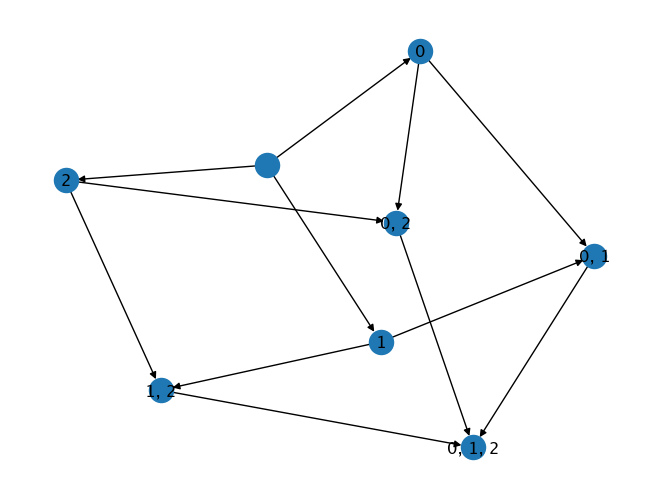

In [12]:
# compute persistent homology and simplex tree
import networkx as nx
layer = 2
head = 1
context_vectors = context[0][layer][head]
persistent_homology_0, simplex_tree_0 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[0], text_1[0])

# plot the simplex tree
plot_simplex_tree(simplex_tree_0)



/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


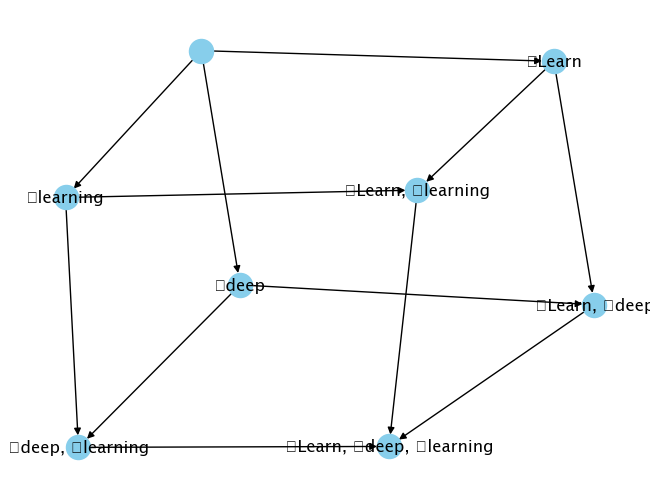

In [13]:
token_ids = tokenizer.encode(text_1[0], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

plot_simplex_tree_with_tokens(simplex_tree_0, tokens)

### Plotting the Simplex Tree as a Tree

Here we filter out the edges that give inclusions that happen at later filtration values than the first, that is, we only include the edges indication inclusions that happen first in the filtration order. We also only draw inclusions from one dimension lower. 

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_53913/4059678099.py:197: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


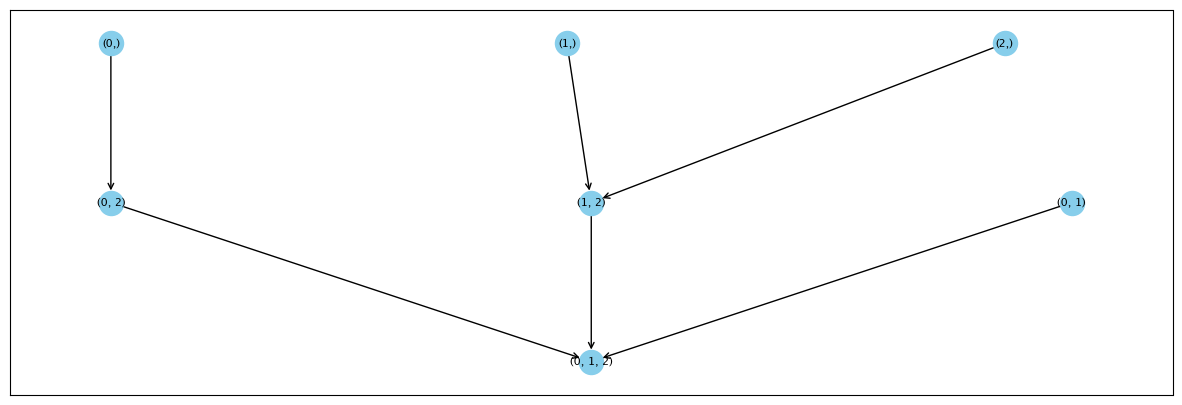

In [14]:
# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree(simplex_tree_0)

### Using a Different Head

Notice in the following that the structure of the tree is different since we are using a different head. This means the head parses the sentence differently from the above attention head. 

/var/folders/1h/8r110l8x0gx4230j9ml6qptm0000gn/T/ipykernel_53913/4059678099.py:234: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which hasknown issues and is not actively maintained. Consider usingnx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(G, prog='dot')


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/Users/amelieschreiber/vscode_projects/vision_persistent_homology/.conda/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9601 (\N{LOWER ONE EIGHTH BLOCK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


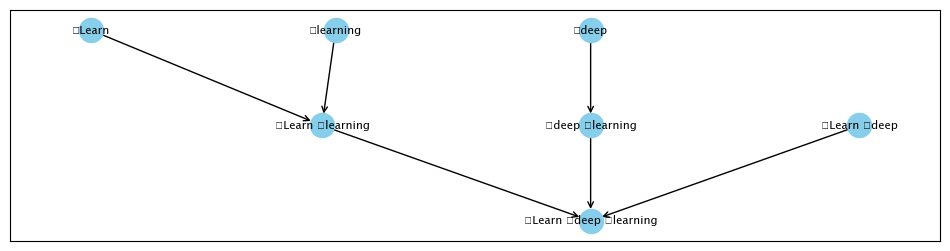

In [15]:
token_ids = tokenizer.encode(text_1[0], add_special_tokens=False)
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# now you can proceed with the rest of your code
# compute persistent homology and simplex tree
layer = 11
head = 5
context_vectors = context[0][layer][head]
persistent_homology_0, simplex_tree_0 = compute_phrase_distances_and_homology(tokenizer, context_vectors, text_1[0], text_1[0])

# In your function, after the simplex_tree is created:
plot_simplex_tree_as_tree_with_tokens(simplex_tree_0, tokens)